<a href="https://colab.research.google.com/github/teoberto/FirstSteps/blob/main/z_score_modificado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Detecção de anomalia por meio da técnica z-score modificado, para um melhor tratamento do impacto dos outliers no z-score.**

Importações

In [1]:
import pandas as pd
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings

Configurações

In [2]:
# Suprimir a warning específica
warnings.filterwarnings("ignore", message="The frame.append method is deprecated and will be removed from pandas in a future version.")


# Funções

**Z-score modificado**


[Técnica de detecção de anomalia](https://blog.dp6.com.br/t%C3%A9cnicas-de-detec%C3%A7%C3%A3o-de-anomalias-parte-ii-99ecb90f93b)

In [3]:
# Cáculo do desvio absoluto da mediana (MAD — Median of the absolute deviation)
def calcula_mad(s):
    mediana = np.median(s)
    diff = abs(s-mediana)
    MAD = np.median(diff)
    return MAD

In [4]:
# Cálculo do z_score modificado

def calcula_z_score_mod(x, mediana, MAD):
    return 0.6745*(x-mediana)/MAD

Média truncada (trim)

In [5]:
# Definindo a função para calcular a média trim
def calcula_trim_mean(group):
    return stats.trim_mean(group, proportiontocut=0.1)

# Data frame

Base de dados [iris](https://gist.github.com/netj/8836201)

In [6]:
# Carregar o conjunto de dados Iris
#iris = pd.read_csv('/content/drive/MyDrive/datasets/iris.csv')
iris = pd.read_csv('https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv')

# Criar um DataFrame do Pandas
df = pd.DataFrame(iris)

In [7]:
# inclui manualmente outliers
df = df.append([{"sepal.length":100,"variety":"Setosa"},{"sepal.length":50,"variety":"Virginica"}])


In [8]:
df

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica
149,5.9,3.0,5.1,1.8,Virginica
0,100.0,NaN,NaN,NaN,Setosa


# Detecção de anomalia

In [9]:
# Desvio absoluto da media e mediana
MAD = calcula_mad(df["sepal.length"])
mediana = np.median(df["sepal.length"])
MAD, mediana

(0.7000000000000002, 5.8)

In [10]:
# Média, mediana, quantidade e desvio absoluto da mediana (MAD) por "variety"
grouped = df.groupby('variety', group_keys=True)['sepal.length']

# Calcular as métricas de agregação
result = grouped.agg([
    ('media', 'mean'),
    ('mediana', 'median'),
    ('desvio_padrao','std'),
    #('vlr_total', 'sum'),
    ('qtd', 'count'),
    ('mad_valor', calcula_mad)
]).reset_index()

result

,variety,media,mediana,desvio_padrao,qtd,mad_valor
0,Setosa,6.868627,5.0,13.306397,51,0.20
1,Versicolor,5.936000,5.9,0.516171,50,0.35
2,Virginica,7.439216,6.5,6.111402,51,0.40


In [11]:
# Acrescenta as métricas por "variety" ao data frame principal
df_final = pd.merge(df, result, on='variety', how='left')
df_final

,sepal.length,sepal.width,petal.length,petal.width,variety,media,mediana,desvio_padrao,qtd,mad_valor
0,5.1,3.5,1.4,0.2,Setosa,6.868627,5.0,13.306397,51,0.2
1,4.9,3.0,1.4,0.2,Setosa,6.868627,5.0,13.306397,51,0.2
2,4.7,3.2,1.3,0.2,Setosa,6.868627,5.0,13.306397,51,0.2
3,4.6,3.1,1.5,0.2,Setosa,6.868627,5.0,13.306397,51,0.2
4,5.0,3.6,1.4,0.2,Setosa,6.868627,5.0,13.306397,51,0.2
...,...,...,...,...,...,...,...,...,...,...
147,6.5,3.0,5.2,2.0,Virginica,7.439216,6.5,6.111402,51,0.4
148,6.2,3.4,5.4,2.3,Virginica,7.439216,6.5,6.111402,51,0.4
149,5.9,3.0,5.1,1.8,Virginica,7.439216,6.5,6.111402,51,0.4
150,100.0,NaN,NaN,NaN,Setosa,6.868627,5.0,13.306397,51,0.2


In [12]:
# Cálculo do z-score
df_final["z_score"] = (df_final["sepal.length"]-df_final["media"])/df_final["desvio_padrao"]

In [13]:
# Cálculo do z-score modificado
df_final["z_score_mod"] = (0.6745*(df_final["sepal.length"]-df_final["mediana"]))/df_final["mad_valor"]

In [14]:
df_anomalias = df_final[abs(df_final.z_score_mod)>3.5]
df_anomalias

,sepal.length,sepal.width,petal.length,petal.width,variety,media,mediana,desvio_padrao,qtd,mad_valor,z_score,z_score_mod
150,100.0,NaN,NaN,NaN,Setosa,6.868627,5.0,13.306397,51,0.2,6.998993,320.387500
151,50.0,NaN,NaN,NaN,Virginica,7.439216,6.5,6.111402,51,0.4,6.964161,73.351875


In [15]:
df_sem_anomalias = df_final[abs(df_final.z_score_mod)<=3.5]

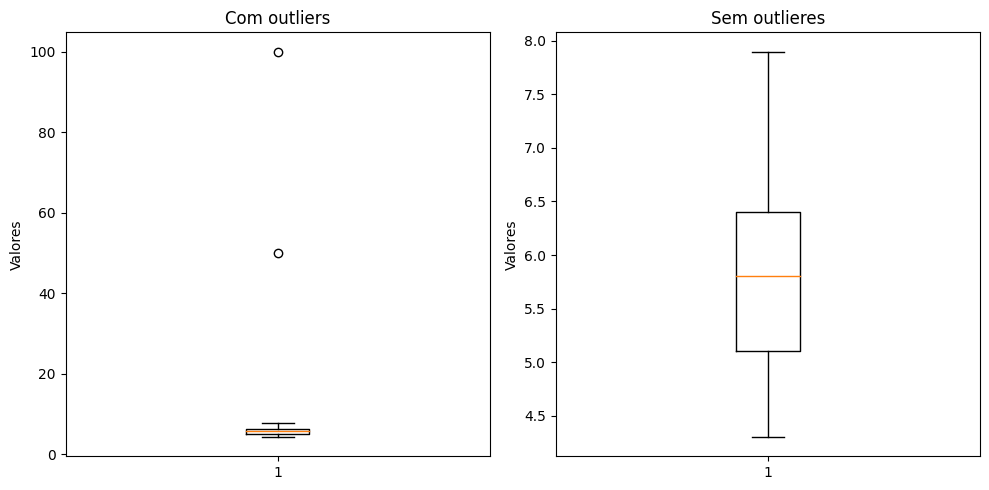

In [16]:
# Criando figuras e eixos
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Criando os boxplots lado a lado
axs[0].boxplot(df['sepal.length'],)
axs[0].set_title('Com outliers')
axs[0].set_ylabel('Valores')

axs[1].boxplot(df_sem_anomalias['sepal.length'])
axs[1].set_title('Sem outlieres')
axs[1].set_ylabel('Valores')

plt.tight_layout()
plt.show()